In [13]:
## At the time of pulling the data, the abstracts # will be less because of not updating the abstract online in pubmed.

In [49]:
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

import re
import nltk
from nltk.corpus import stopwords
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.models.ldamodel import LdaModel
from gensim.models.phrases import Phrases, Phraser
import spacy
import string


import pyLDAvis
import pyLDAvis.gensim
from gensim.utils import lemmatize
from pprint import pprint
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
import warnings

from nltk.tokenize import word_tokenize
%matplotlib inline
warnings.filterwarnings('ignore')

In [7]:
nlp = spacy.load('en', disable=['parser', 'ner'])

In [8]:
covid19 = pd.read_csv("../data/output/covid19.csv")

In [9]:
covid19_abstract = covid19[['Abstract','Title']].dropna().reset_index(drop = True)

In [12]:

covid19_abstract.head()

,Abstract,Title
0,In an effort to expedite the publication of ar...,Advocacy during crisis: Maintaining a legislat...
1,We investigated how the COVID-19 crisis and th...,Genetic correlates of psychological responses ...
2,During virus infection B cells are critical fo...,B cell clonal expansion and convergent antibod...
3,Background Multiple Biomarkers have recently b...,Prognostic value of Cardiac Biomarkers in COVI...
4,Corona virus disease (COVID-19) originated in ...,Association Between Air Pollution in Lima and ...


In [16]:
stop_words = stopwords.words('english')
nlp = spacy.load('en', disable=['parser', 'ner'])
# clean the text using below for loop
clean_text = []
for index in tqdm(range(len(covid19_abstract))):
    #Remove punctuations
    text = re.sub('[^a-zA-Z]', ' ', covid19_abstract['Abstract'][index])

    #Convert to lowercase
    text = text.lower()
    
    #remove special characters and digits
    text=re.sub("(\\d|\\W)+"," ",text)
    
    #Convert to list of words from text
    text = text.split()
    
    # remove stop words after splitting text and joint the words
    text =[word for word in text if word not in stop_words]
    text = " ".join(text)
    # lemmatize words using spacy
    
    doc = nlp(text)
    text=" ".join([token.lemma_ for token in doc])

   # append to clean_text
    clean_text.append(text)
    
covid19_abstract['clean_text'] = clean_text

100%|██████████| 20930/20930 [01:59<00:00, 175.66it/s]


In [17]:
covid19_abstract.head()

,Abstract,Title,clean_text
0,In an effort to expedite the publication of ar...,Advocacy during crisis: Maintaining a legislat...,effort expedite publication article relate cov...
1,We investigated how the COVID-19 crisis and th...,Genetic correlates of psychological responses ...,investigate covid crisis extraordinary experie...
2,During virus infection B cells are critical fo...,B cell clonal expansion and convergent antibod...,virus infection b cell critical production ant...
3,Background Multiple Biomarkers have recently b...,Prognostic value of Cardiac Biomarkers in COVI...,background multiple biomarker recently show el...
4,Corona virus disease (COVID-19) originated in ...,Association Between Air Pollution in Lima and ...,corona virus disease covid originate china dec...


In [18]:
covid19_abstract.shape

(20930, 3)

In [19]:
covid19_abstract.to_csv('../data/output/covid_clean_text.csv', index = False)

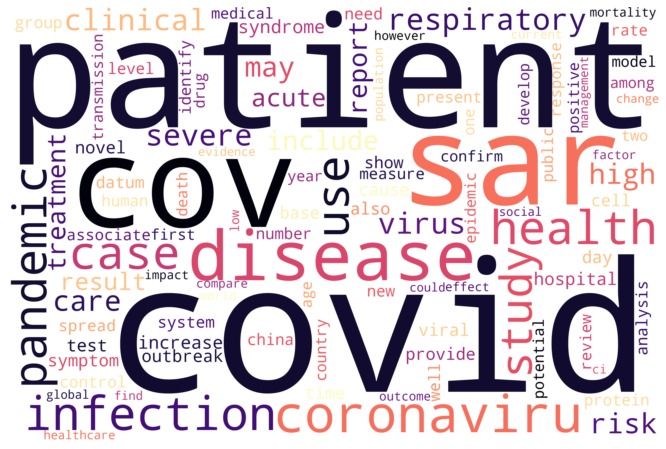

In [24]:
#Word cloud of 100 words in the entire clean text
wordcloud = WordCloud(width = 3000,
    height = 2000,background_color='white',colormap=plt.cm.magma,
                          stopwords=stop_words,
                          max_words=100,
                           
                          random_state=42,collocations=False
                         ).generate(str(clean_text))

#print(wordcloud)
plt.figure(figsize = (30, 8), edgecolor = 'k')
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.savefig("../data/wordcloud_covid19.png")
plt.show()

In [25]:
stop_words = stopwords.words('english')
print(len(stop_words))
remove_words = ['overall','however', 'confirm','present','perform','attempts', 'model','use', 'calculating','performance','trainable',
                'data','result','representations','using','limited','used','feature','proposed','evaluate'
                ,'performance','algorithm','lr','ext','respective','respectively', 'accuracy', 'relatively'
                ,'small','challenge','validation','layer','better','three','detection','show','cnn','li', 
                'small','show','development','training','transfer','twos','cnns','pre','auroc','two','method',
                'parameters','segmentation','convolutional', 'neural', 'network', 'show','task','compare',
                'state','study', 'retrospective', 'datum','prediction','art','require', 'focus', 'base',
                'approach', 'paper', 'present', 'fall', 'due', 'recent', 'exponential', 'increase','analysis',
                'analysis','specificity','basis', 'function', 'kernel', 'area', 'curve', 'auc', 'may', 
                'useful','explore', 'two', 'different','test','models','system','deep', 'learning',
                'approach','require','may', 'useful','information', 'basis','obtain','methods','achieve',
                'level','al', 'research', 'grid', 'also','features', 'techniques', 'hard', 'parameter', 
                'sharing', 'cross', 'stitch', 'train', 'word', 'level', 'however','search', 'currently',
                'trained','article','analytic','datasets','fold', 'cross', 'propose','compared','based',
                'classification','results','dataset','multiple', 'time','architecture','end', 'sensitivity', 
                'specificity','proive','representation','input','technique','large','work','improve','layers',
                'set','learn','experiment','achieved','information','machine','offers', 'high','networks',
                'superior', 'classification', 'accuracy', 'for', 'automated', 'coding', 'support', 'aid', 'address',
               'available','https','important','role', 'application','good','rate','field','new','tool',
               'subject','value','map','quality','application','provide','one','mr', 'false','positive','tune','fine',
                'github','com','precision','recall','long','short','gold', 'standard','problem','demonstrate','apply',
                'well','truth','ground','similarity','coefficient','entity','event','cohort','molecular','goal','knowledge',
                'refer','conditional','name','natural','language','metho','processing','nlp','term','operate',
                'characteristics', 'whole','slide','supplementary', 'significantly', 'improvement','wide','range',
               'hand','craft','open','source','ci','see','outperform']

#identifies and removes duplicates and returns a lits of words
remove_words= list(set(remove_words))
stop_words.extend(remove_words)
print(len(remove_words))
print(len(stop_words))

179
213
392


In [26]:
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
minus_stopwords = remove_stopwords(clean_text)

In [27]:
clean_text = [" ".join(x) for x in minus_stopwords]

In [28]:
def text_to_words(text):
    for sentence in text:
        yield(gensim.utils.simple_preprocess(str(sentence)))  # deacc=True removes punctuations

words_text = list(text_to_words(clean_text))

print(words_text[3])

['background', 'biomarker', 'recently', 'elevated', 'covid', 'respiratory', 'infection', 'multi', 'organ', 'dysfunction', 'regard', 'prognostic', 'cardiac', 'biomarker', 'relate', 'disease', 'severity', 'cardiac', 'injury', 'inconsistent', 'question', 'meta', 'summarize', 'evidence', 'regard', 'prognostic', 'relevance', 'cardiac', 'biomarkers', 'publish', 'report', 'design', 'pubmed', 'inception', 'april', 'median', 'cardiac', 'biomarker', 'critically', 'ill', 'versus', 'non', 'critically', 'ill', 'covid', 'patient', 'patient', 'die', 'versus', 'survive', 'weight', 'mean', 'difference', 'wmd', 'confidence', 'interval', 'group', 'calculate', 'combine', 'random', 'effect', 'meta', 'odd', 'ratio', 'mortality', 'cardiac', 'injury', 'combine', 'reporting', 'troponin', 'higher', 'covid', 'patient', 'die', 'critically', 'ill', 'versus', 'alive', 'critically', 'ill', 'wmd', 'cardiac', 'injury', 'independently', 'associate', 'odd', 'mortality', 'difference', 'bnp', 'group', 'significant', 'diff

In [29]:
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [30]:
lemmatized_words = lemmatization(words_text, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

In [17]:
#clean_text = [" ".join(x) for x in minus_stopwords]

                   Bigram        Freq
0          covid pandemic  256.361939
1       acute respiratory  243.225180
2           covid patient  203.300389
3            severe acute  201.037351
4           public health  143.550793
5             health care  118.398355
6         covid infection  118.089502
7           patient covid  116.459076
8    respiratory syndrome   97.940963
9           mental health   81.892433
10         intensive care   75.469425
11         clinical trial   71.491096
12            risk factor   70.692684
13     infectious disease   67.907785
14             covid case   65.710071
15        immune response   65.634402
16   protective equipment   63.928276
17         covid outbreak   63.201266
18               year old   61.688018
19    personal protective   61.013105
20               age year   58.622511
21        global pandemic   58.496898
22              care unit   57.209704
23       health emergency   55.796370
24        treatment covid   55.705342
25        vi

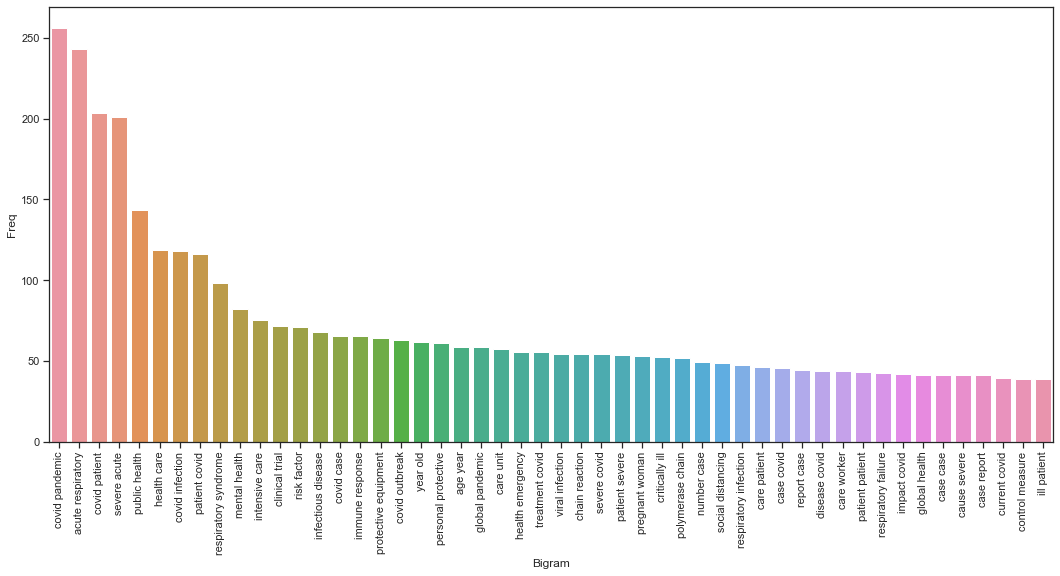

In [31]:
#Most frequently occuring bigrams in the data. plot both bar plot and word cloud of bigrams in the data 
def top_bi_grams(clean_text, n=None):
    clean_text = [" ".join(x) for x in lemmatized_words]
    vectorizer = TfidfVectorizer(ngram_range = (2,2), min_df = 2,stop_words=stop_words).fit(clean_text)
    bows = vectorizer.transform(clean_text)
    sumwords = bows.sum(axis=0) 
    words_freq = [(word, sumwords[0, idx]) for word, idx in     
                  vectorizer.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], 
                reverse=True)
    return words_freq[:n]

top_bigrams = top_bi_grams(clean_text, n=50)
top_bigrams_df = pd.DataFrame(top_bigrams)
top_bigrams_df.columns=["Bigram", "Freq"]
print(top_bigrams_df)

#Barplot of most freq Bi-grams
sns.set(rc={'figure.figsize':(18,8)}, style ='white' )
sns.set_style("ticks")

h=sns.barplot(x="Bigram", y="Freq", data=top_bigrams_df)
h.set_xticklabels(h.get_xticklabels(), rotation=90);

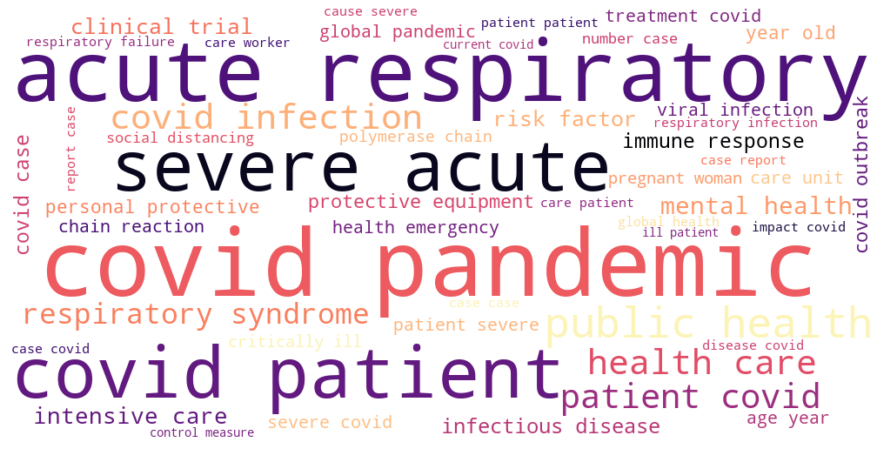

In [36]:
bigrams = {}
for w, x in top_bigrams_df.values:
    bigrams[w] = x
wordcloud = WordCloud(width = 1000,
    height = 500,background_color='white',colormap=plt.cm.magma,margin=5,
                      relative_scaling=1, collocations=False)
wordcloud.generate_from_frequencies(bigrams)
plt.figure(figsize = (30, 8),
    
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.savefig("../data/word_cloud_covid19.png", bbox_inches='tight')
plt.show()

In [37]:
bigram = Phrases(lemmatized_words, min_count=1, threshold=100)
trigram = Phrases(lemmatized_words, min_count=1, threshold=100)
bigrams_mod = Phraser(bigram)
trigrams_mod = Phraser(trigram)

In [38]:
def bigrams(texts):
    return [bigrams_mod[doc] for doc in texts]
words_bigrams = bigrams(lemmatized_words)

def trigrams(texts):
    return [trigrams_mod[doc] for doc in texts]
words_trigrams = trigrams(lemmatized_words)

In [39]:
# Create Dictionary
id2word = corpora.Dictionary(words_bigrams)


# Create Corpus
texts = words_bigrams

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:2])


[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 2), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1)], [(2, 2), (16, 2), (17, 1), (18, 1), (19, 2), (20, 1), (21, 2), (22, 4), (23, 1), (24, 3), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 3), (34, 2), (35, 1), (36, 1), (37, 1), (38, 1), (39, 1), (40, 2), (41, 1), (42, 1), (43, 1), (44, 1), (45, 1), (46, 1), (47, 1), (48, 1), (49, 1), (50, 2), (51, 2), (52, 1), (53, 1), (54, 2), (55, 1), (56, 1), (57, 1), (58, 1), (59, 1), (60, 2), (61, 2), (62, 1), (63, 1)]]


In [40]:
id2word[21]

'behavioural'

In [41]:
# Build LDA model
lda_model = LdaModel(corpus=corpus,
                     id2word=id2word,
                     num_topics=14, 
                     random_state=100,
                     update_every=1,
                     chunksize=1000,
                     passes=25,
                     alpha='auto',
                     per_word_topics=True)

In [42]:
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.087*"case" + 0.032*"number" + 0.021*"transmission" + 0.018*"covid" + '
  '0.017*"infection" + 0.017*"country" + 0.016*"report" + 0.016*"epidemic" + '
  '0.015*"death" + 0.014*"measure"'),
 (1,
  '0.032*"mental" + 0.030*"covid" + 0.024*"health" + 0.023*"psychological" + '
  '0.021*"survey" + 0.018*"stress" + 0.017*"anxiety" + 0.015*"report" + '
  '0.015*"participant" + 0.014*"student"'),
 (2,
  '0.126*"patient" + 0.048*"covid" + 0.027*"case" + 0.026*"clinical" + '
  '0.023*"symptom" + 0.013*"child" + 0.013*"treatment" + 0.011*"day" + '
  '0.011*"diagnosis" + 0.010*"find"'),
 (3,
  '0.034*"sample" + 0.019*"testing" + 0.018*"diagnostic" + 0.017*"detect" + '
  '0.012*"clinical" + 0.012*"negative" + 0.012*"antibody" + 0.011*"pcr" + '
  '0.011*"reaction" + 0.010*"specific"'),
 (4,
  '0.071*"virus" + 0.041*"protein" + 0.039*"human" + 0.026*"novel" + '
  '0.025*"sequence" + 0.020*"vaccine" + 0.017*"strain" + 0.017*"identify" + '
  '0.017*"coronaviruse" + 0.017*"gene"'),
 (5,
  '0.068

In [43]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=words_bigrams, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -8.156070094827092

Coherence Score:  0.5586110293055129


In [44]:
# code repurposed from https://datascienceplus.com/evaluation-of-topic-modeling-topic-coherence/
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model=LdaModel(corpus=corpus, id2word=id2word, num_topics=num_topics)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

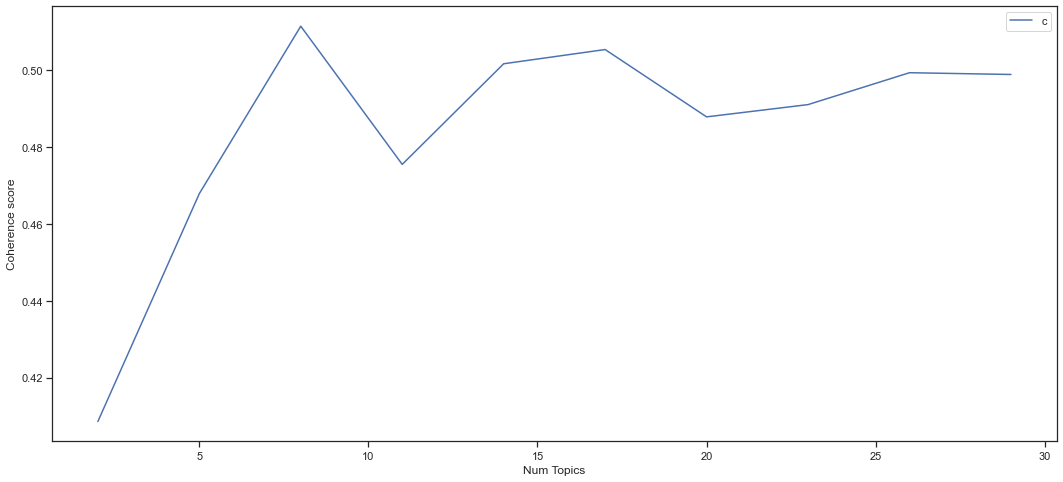

In [45]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=words_bigrams, start=2, limit=30, step=3)
# Show graph

limit=30; start=2; step=3;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [46]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
10     0.036643  0.009727       1        1  22.412941
5     -0.053945 -0.225453       2        1  12.258868
2      0.151676 -0.154809       3        1  11.192488
0      0.039251 -0.039872       4        1   8.029367
6      0.158172  0.108058       5        1   7.763834
7      0.175878 -0.149329       6        1   6.531754
9      0.101575  0.072256       7        1   5.783242
4     -0.264087 -0.065043       8        1   4.589819
1      0.140332  0.051382       9        1   4.513408
11    -0.265092  0.013363      10        1   4.025193
3     -0.063356  0.036921      11        1   4.002752
12    -0.208574  0.005697      12        1   3.869678
13    -0.005969  0.352004      13        1   2.574825
8      0.057494 -0.014903      14        1   2.451828, topic_info=             Term          Freq         Total Category  logprob  loglift
94        patient  33655.000000  33655.000000  Default  30.0000  30.0000
153          case  15061.000000  15061.000000  Default  29.0000  29.0000
143   respiratory  11822.000000  11822.000000  Default  28.0000  28.0000
293          care   9654.000000   9654.000000  Default  27.0000  27.0000
68           cell   5662.000000   5662.000000  Default  26.0000  26.0000
...           ...           ...           ...      ...      ...      ...
19         assess    294.223907   1982.684082  Topic14  -4.7654   1.8005
141        regard    265.602112   1903.938721  Topic14  -4.8677   1.7387
1769       author    221.799225    684.569336  Topic14  -5.0479   2.5813
203      identify    258.937073   4356.742676  Topic14  -4.8931   0.8854
349          find    217.571686   4939.572266  Topic14  -5.0672   0.5858

[926 rows x 6 columns], token_table=      Topic      Freq            Term
term                                 
5372     10  0.990534  abdominal_pain
1398      3  0.996941        abnormal
1400      3  0.996187     abnormality
288       1  0.320214          access
288       5  0.596991          access
...     ...       ...             ...
189       8  0.022397            year
189       9  0.072535            year
189      12  0.002800            year
3930      2  0.071211        zoonotic
3930      8  0.925743        zoonotic

[1892 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[11, 6, 3, 1, 7, 8, 10, 5, 2, 12, 4, 13, 14, 9])

In [47]:
pyLDAvis.save_html(vis, '../data/ldacovid.html')

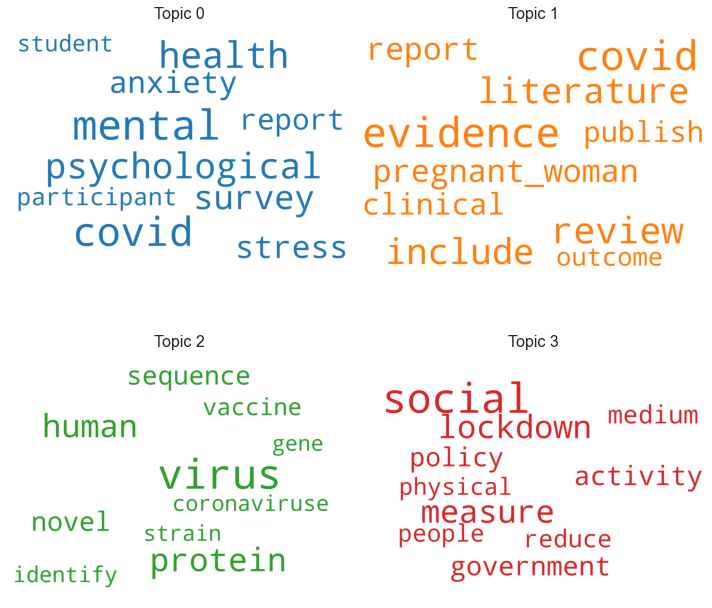

In [55]:
#https://www.machinelearningplus.com/nlp/topic-modeling-visualization-how-to-present-results-lda-models/
# 1. Wordcloud of Top N words in each topic

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'
cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.savefig("../data/topic_words_covid19.png", bbox_inches='tight')
plt.show()